# Visualise the tracked MHWs

In [1]:
import xarray as xr
import numpy as np
import dask

from tempfile import TemporaryDirectory
from getpass import getuser
from pathlib import Path
from dask.distributed import Client, LocalCluster
import subprocess
import re

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
scratch_dir = Path('/scratch') / getuser()[0] / getuser() / 'mhws' 

## Start Dask Cluster

In [3]:
cluster_scratch = Path('/scratch') / getuser()[0] / getuser() / 'clients'
dask_tmp_dir = TemporaryDirectory(dir=cluster_scratch)
dask.config.set(temporary_directory=dask_tmp_dir.name)

## Local Cluster
cluster = LocalCluster(n_workers=32, threads_per_worker=4)
client = Client(cluster)

remote_node = subprocess.run(['hostname'], capture_output=True, text=True).stdout.strip().split('.')[0]
port = re.search(r':(\d+)/', client.dashboard_link).group(1)
print(f"Forward with Port = {remote_node}:{port}")

client.dashboard_link

Forward with Port = l30147:8787


'http://127.0.0.1:8787/status'

## Import Processed Data

In [4]:
blobs = xr.open_dataset(scratch_dir / '02_tracked_dask.nc', chunks={'time': 50, 'lat': -1, 'lon': -1}).labels
blobs

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.DataArray 'labels' (time: 13878, lat: 721, lon: 1440)> Size: 115GB
dask.array<open_dataset-labels, shape=(13878, 721, 1440), dtype=float64, chunksize=(50, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
    decimal_year  (time) float64 111kB dask.array<chunksize=(50,), meta=np.ndarray>
  * lat           (lat) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * lon           (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time          (time) datetime64[ns] 111kB 2002-01-01T23:59:00 ... 2039-12...
Attributes:
    size quantile threshold:    0.5
    percent area reject:        0.09173237669123473
    final objects tracked:      16497
    percent area accept:        0.9082676233087653
    radius:                     8
    inital objects identified:  344005
    min area:                   748.0

In [5]:
ds = xr.open_zarr(str(scratch_dir / '01_preprocess_dask.zarr'), chunks={'time': 50, 'lat': -1, 'lon': -1})
ds

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/xarray/core/dataset.py:273: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 50. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


<xarray.Dataset> Size: 234GB
Dimensions:           (dayofyear: 366, time: 13879, lat: 721, lon: 1440)
Coordinates:
  * dayofyear         (dayofyear) int64 3kB 1 2 3 4 5 6 ... 362 363 364 365 366
    decimal_year      (time) float64 111kB dask.array<chunksize=(50,), meta=np.ndarray>
  * lat               (lat) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * lon               (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * time              (time) datetime64[ns] 111kB 2002-01-01T23:59:00 ... 203...
Data variables:
    features_notrend  (time, lat, lon) float64 115GB dask.array<chunksize=(50, 721, 1440), meta=np.ndarray>
    mask              (lat, lon) bool 1MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    ssta_notrend      (time, lat, lon) float64 115GB dask.array<chunksize=(50, 721, 1440), meta=np.ndarray>
    stdev             (dayofyear, lat, lon) float64 3GB dask.array<chunksize=(366, 721, 1440), meta=np.ndarray>
Attributes:
    climatology:  entire period
    description:  ICON erc1011 preprocessed for Ocetrac-dask
    threshold:    95th percentile

## Plot some Blobs

In [6]:
blob_subset = blobs.sel(time=slice('2020-01-01', '2021-01-01')).resample(time='MS').first()
maxl = blob_subset.max().compute().item()
minl = blob_subset.min().compute().item()

In [7]:
cm = ListedColormap(np.random.random(size=(int(maxl-minl), 3)).tolist())

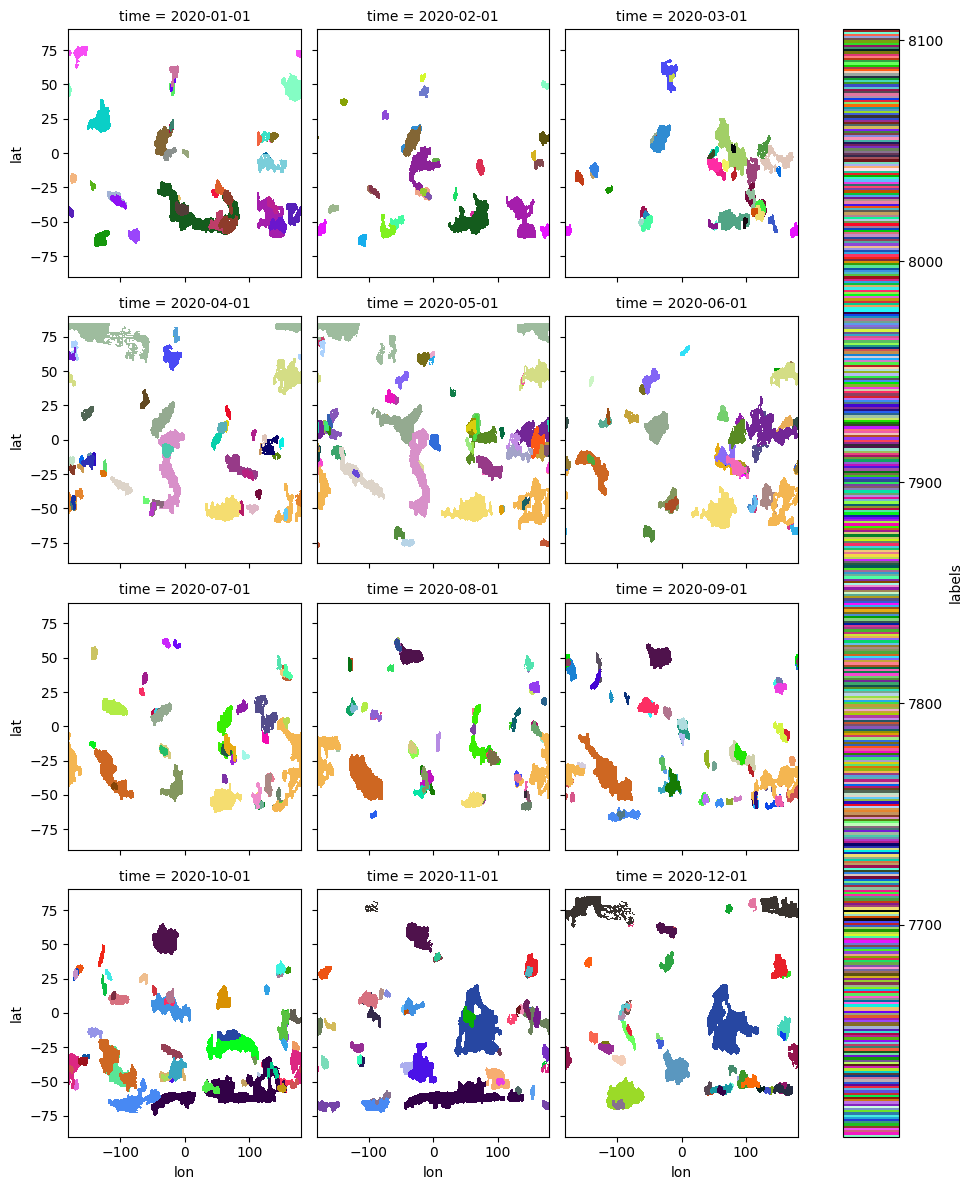

In [8]:
blobs_first_day = blobs.sel(time=slice('2020-01-01', '2020-12-31')).resample(time='MS').first()
blobs_first_day.plot(col='time', col_wrap=3, cmap=cm)

## Global MHW Frequency

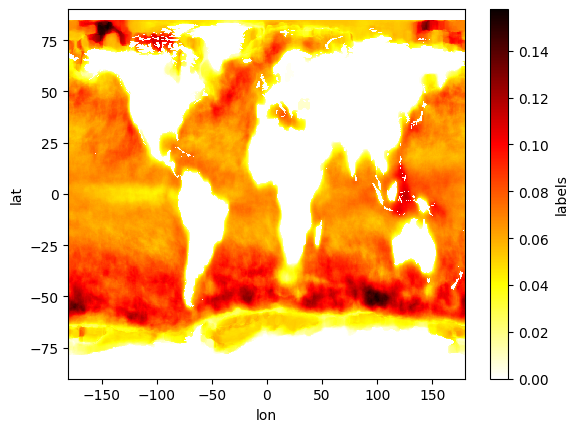

In [9]:
mhw_frequency = xr.where((blobs == 0) | np.isnan(blobs), 0.0, 1.0).mean('time')
mhw_frequency.plot(cmap='hot_r')

## Plot STD Rolling Mean used for Normalisation

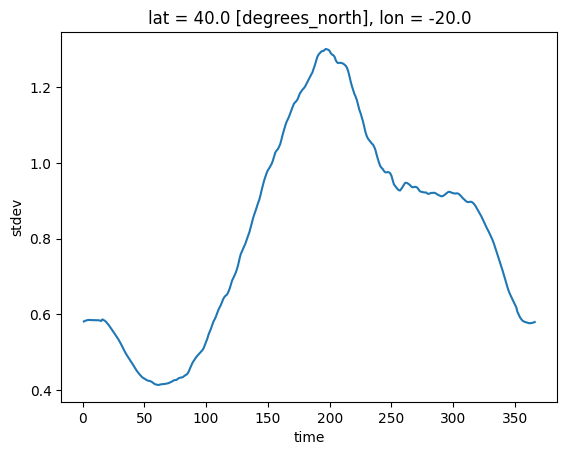

In [10]:
ds.stdev.sel(lat=40,lon=-20, method='nearest').plot()

## Find the longest MHWs

In [11]:
final_objects_tracked = blobs.attrs['final objects tracked']
labels = np.arange(final_objects_tracked)

occurrence_array = xr.apply_ufunc(
    lambda blobs_data, labels: np.isin(labels, blobs_data[..., np.newaxis]),  # Check presence...
    blobs,
    input_core_dims=[['lat', 'lon']],
    output_core_dims=[['label']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[bool],
    output_sizes={'label': final_objects_tracked},
    kwargs={'labels': labels}
)

/tmp/ipykernel_1900144/2121563198.py:4: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  occurrence_array = xr.apply_ufunc(


In [12]:
label_occurrence = occurrence_array.sum(dim='time').compute()

In [13]:
longest_mhws = label_occurrence.argsort()[::-1]

In [14]:
for label in longest_mhws[:10].values:
    print(f"Label: {label}, Time: {label_occurrence.sel(label=label).item()} days")

Label: 11454, Time: 809 days
Label: 6919, Time: 483 days
Label: 12071, Time: 415 days
Label: 1, Time: 405 days
Label: 12787, Time: 390 days
Label: 422, Time: 363 days
Label: 507, Time: 324 days
Label: 4964, Time: 322 days
Label: 775, Time: 318 days
Label: 11790, Time: 306 days


## Plot a few long MHWs

In [15]:
# mhw_intensity = xr.where(blobs == longest_mhws[:9], 1, 0).sum(dim='time')

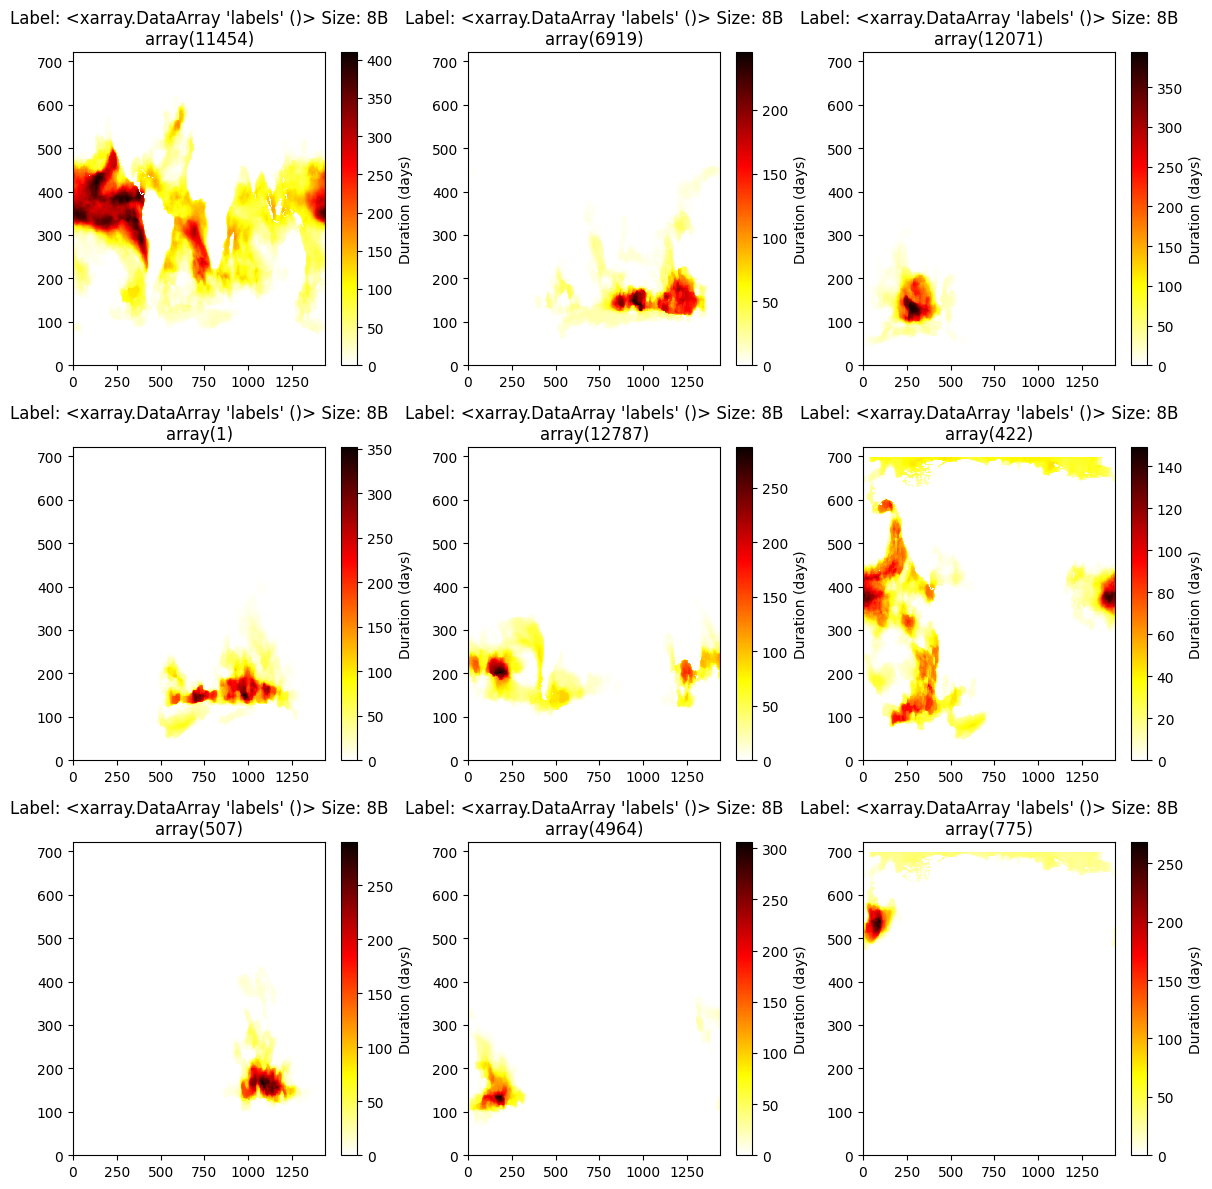

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i, label in enumerate(longest_mhws[:9]):
    ax = axes[i]
    mhw_intensity = xr.where(blobs == longest_mhws[i], 1, 0).sum(dim='time')
    c = ax.pcolor(mhw_intensity, cmap='hot_r')  #.isel(label=i)
    cbar = fig.colorbar(c, ax=ax, orientation='vertical')
    cbar.set_label('Duration (days)')
    ax.set_title(f'Label: {label}')

# Adjust layout
plt.tight_layout()
plt.show()